# Calculating sea ice extent

> history \| Create August 2023 <br/>

<a href="https://polarwatch.noaa.gov/" target="_blank">NOAA PolarWatch</a> distributes gridded and tabular oceanographic data for polar regions. Many of the PolarWatch data products include sea ice related satellite data.  

Sea ice extent describes the area of ice coverage at a given time.  It is calculated using sea ice concentration data, and plays an important role as an environmental indicator to climate research. 


In this exercise, we will learn to calculate sea ice extent using sea ice concentration data (<a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">reference</a>).  

*The sea ice extent calculation is done using the grid area and sea ice concentration.  It should be noted that no bias or uncertainty correction is applied in the estimation process.*

**The exercise demonstrates the following techniques:**
-   Downloading and saving a netcdf file from PolarWatch ERDDAP data server
-   Accessing satellite data and metadata in polar stereographic projection 
-   Compute sea ice extent using sea ice concentration data
-   Mapping sea ice extent 

**Datasets used:**
-   sea ice concentration from the northern hemisphere 

**Python packages used:**
-   xarray (reading and analyzing data)
-   pyproj (reprojection)
-   cartopy (mapping projection)
-   matplotlib (mapping)
-   numpy (data analysis, manipulation)



### Reference
- <a href="https://nsidc.org/learn/ask-scientist/what-difference-between-sea-ice-area-and-extent#:~:text=But%20NSIDC%20scientists%2C%20like%20most,the%20total%20in%20their%20entirety.&text=Calculating%20sea%20ice%20extent%20means,with%2015%20percent%20or%20more.">NSIDC Sea ice area vs extent</a>
- <a href="https://nsidc.org/arcticseaicenews/">NSIDC Arctic Sea Ice News & Analysis</a>
- <a href="https://www.climate.gov/news-features/understanding-climate/understanding-climate-antarctic-sea-ice-extent">Climate.gov Understanding Climate: sea ice extent</a>



## Import packages

In [131]:
# import cartopy.crs as ccrs
import urllib.request
import pyproj
import xarray as xr
import numpy as np
import pyproj
from pyproj import CRS
from pyproj import Transformer as transformer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

# from matplotlib import pyplot as plt 

## Arctic Sea Ice Concentration Data

To demonstrate sea ice extent estimation, one time step NSIDC Sea Ice Concentration data from passive microwave sensors will be used.
This dataset includes sea ice concentration data from the northern hemisphere, and is produced by the NOAA/NSIDC and annually processed, using the Climate Data Record algorithm.  The resolution is 25km, meaning each grid in this data set represents a value that covers a 25km by 25km area.  


**Data**

*Sea Ice Concentration*, NOAA/NSIDC Climate Data Record V4, Northern Hemisphere, 25km, Science Quality, 1978-2022, Monthly




**Userful links**

-   <a href="https://nsidc.org/data/g02202/versions/4" target="_blank">NSIDC Data Product Description</a>
-   <a href="https://nsidc.org/sites/default/files/g02202-v004-userguide_1_1.pdf" target="_blank">NSIDC Data Product User Guide (pdf)</a>
-   <a href="https://polarwatch.noaa.gov/catalog/ice-sq-nh-nsidc-cdr-v4/preview/?dataset=daily&var=cdr_seaice_conc&time_min=2022-05-31T00:00:00Z&time_max=2022-05-31T00:00:00Z&proj=epsg3413&colorBar=KT_ice|||0|1|" target="_blank">NOAA PolarWatch Data Product Page (download, preview)</a>


## Importing data

https://nsidc.org/data/nsidc-0771/versions/1



In [2]:
url="https://polarwatch.noaa.gov/erddap/griddap/nsidcG02202v4nhmday.nc?cdr_seaice_conc_monthly[(2022-12-01T00:00:00Z):1:(2022-12-01T00:00:00Z)][(4843696.04):1:(-4858210.64)][(-3850000.0):1:(3750000.0)]"
urllib.request.urlretrieve(url, "sic.nc")

('sic.nc', <http.client.HTTPMessage at 0x13210a310>)

In [102]:
# open and assign data from the file to a variable ds using xarray
ds = xr.open_dataset("sic.nc")


## Importing grid

https://nsidc.org/data/nsidc-0771/versions/1

In [159]:
grid_area = xr.open_dataset("../resources/NSIDC0771_CellArea_PS_N25km_v1.0.nc")

<xarray.DataArray 'area' (time: 1)>
array([4.2655315e+08])
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01
    ygrid    float32 4.838e+06
    xgrid    float32 -3.838e+06


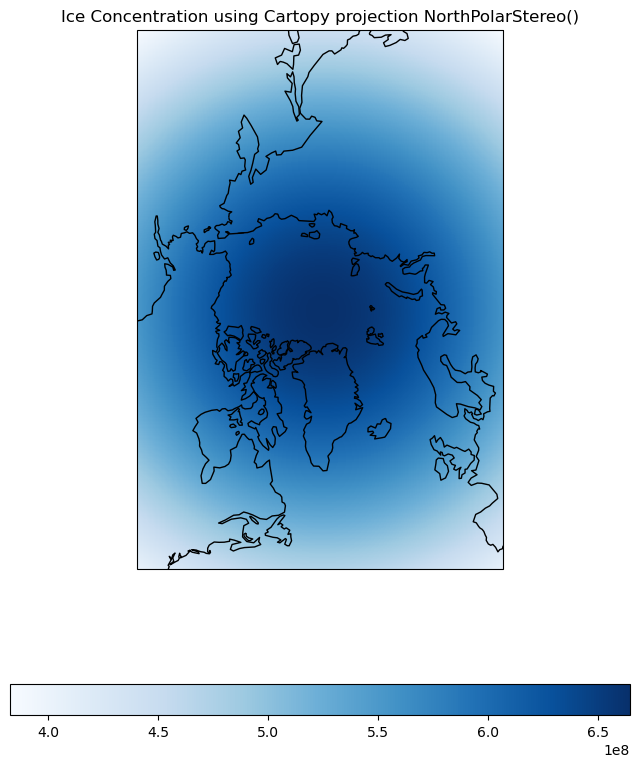

In [174]:
# set mapping crs to Cartopy's North Polar Stereo graphic
crs_epsg = ccrs.NorthPolarStereo(central_longitude=-45)

# set figure size
fig = plt.figure(figsize=[10, 10])

# set the map projection and associated boundaries
ax = plt.axes(projection = crs_epsg)
ax.coastlines()
ax.add_feature(cfeature.LAND)
print(seaice_ds['area'][0][0])
# set the data crs using 'transform' 
# set the data crs as described in the netcdf metadata
cs = ax.pcolormesh(grid_area['x'], grid_area['y'],grid_area['cell_area'] , 
                   cmap=plt.cm.Blues,  transform= ccrs.NorthPolarStereo(true_scale_latitude=70, central_longitude=-45)) #transform default is basemap specs

fig.colorbar(cs, ax=ax, location='bottom', shrink =0.8)
ax.set_title('Ice Concentration using Cartopy projection NorthPolarStereo()')

plt.show()

In [108]:
# subsetting grid area to match dataset

xgrid = ds['xgrid'].values
ygrid = ds['ygrid'].values

xmax, xmin, ymax, ymin = np.max(xgrid), np.min(xgrid), np.max(ygrid), np.min(ygrid)

sub_area = ds_area.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))

## Adding area to the DataSet

In [110]:
# add grid area to the dataset
cell_area = sub_area.cell_area.values
ds['area'] = (('ygrid', 'xgrid'), cell_area)

In [169]:
# subset the dataset to exclude flag values
seaice_ds = ds.where(ds.cdr_seaice_conc_monthly <= 1)

icearea = seaice_ds.area * seaice_ds.cdr_seaice_conc_monthly[0][:]
tot_icearea = np.sum(icearea)
tot_icearea

ext = seaice_ds.area * xr.where(seaice_ds.cdr_seaice_conc_monthly[0][:] < 0.15, 0, 1)
extent = np.sum(ext)/1000000


In [150]:
seaice_ds = seaice_ds.squeeze('time', drop=True)

In [155]:
seaice_ds.area * seaice_ds.cdr_seaice_conc_monthly

<xarray.DataArray (ygrid: 389, xgrid: 304)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * ygrid    (ygrid) float32 4.838e+06 4.812e+06 ... -4.838e+06 -4.862e+06
  * xgrid    (xgrid) float32 -3.838e+06 -3.812e+06 ... 3.712e+06 3.738e+06

## Mapping extent

<xarray.DataArray 'area' (time: 1)>
array([4.2655315e+08])
Coordinates:
  * time     (time) datetime64[ns] 2022-12-01
    ygrid    float32 4.838e+06
    xgrid    float32 -3.838e+06


ValueError: too many values to unpack (expected 2)

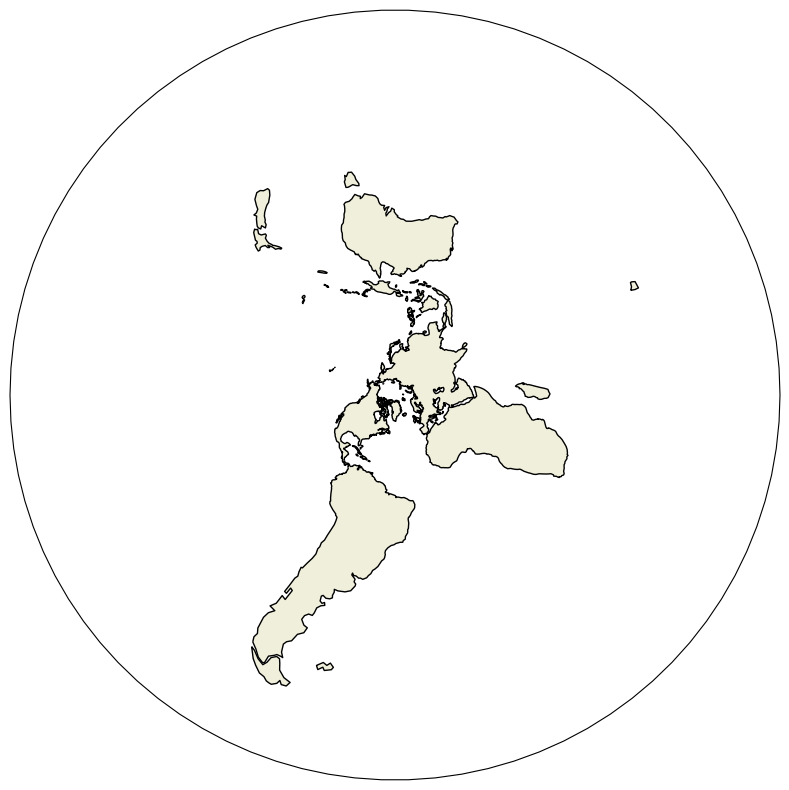

In [172]:
# set mapping crs to Cartopy's North Polar Stereo graphic
crs_epsg = ccrs.NorthPolarStereo(central_longitude=-45)

# set figure size
fig = plt.figure(figsize=[10, 10])

# set the map projection and associated boundaries
ax = plt.axes(projection = crs_epsg)
ax.coastlines()
ax.add_feature(cfeature.LAND)

# set the data crs using 'transform' 
# set the data crs as described in the netcdf metadata
cs = ax.pcolormesh(seaice_ds['xgrid'], seaice_ds['ygrid'],seaice_ds['area'] , 
                   cmap=plt.cm.Blues,  transform= ccrs.NorthPolarStereo(true_scale_latitude=70, central_longitude=-45)) #transform default is basemap specs

fig.colorbar(cs, ax=ax, location='bottom', shrink =0.8)
ax.set_title('Ice Concentration using Cartopy projection NorthPolarStereo()')

plt.show()

In [117]:
# compute phi
def compute_phi(x,y):
    transformer = pyproj.Transformer.from_crs("3413", "4326")
    lat, lon = transformer.transform(x, y) #x,y are center of a grid
    phi = np.radians(lat)
    return phi

# compute actual cell area
def compute_cell_area(x,y, proj):
    # Constants
    R = 6371.0  # Earth radius in km
    k0 = pyproj.CRS("EPSG:3413").to_dict().get('k_0', 1.0)
    area_xy = 625 #25k by 25k resolution 

    #proj = pyproj.Proj("EPSG:3413")  if not passed

    phi = compute_phi(x, y)

    # Compute the Jacobian determinant for the Polar Stereographic projection
    jacobian_determinant = (2 * k0 * R**2) / (1 + np.sin(phi))

    # Actual area on Earth's surface
    actual_area = jacobian_determinant * area_xy
    return actual_area


In [125]:
import csv
filename = "data_check.csv"

# Write to CSV
with open(filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(ds['area'].values)

print(f"Data written to {filename}")

Data written to data_check.csv


In [118]:
proj = pyproj.Proj("EPSG:3413") 
xx, yy = np.meshgrid(x,y)
actual_area = compute_cell_area(xx, yy, proj)
# transformer = pyproj.Transformer.from_crs("3413", "4326")
# lat, lon = transformer.transform(x[0], y[0]) #x,y are center of a grid

/Users/sunbak/mambaforge/envs/code_gallery/lib/python3.11/site-packages/pyproj/crs/crs.py:1296: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


In [121]:
gridextent = xr.where(da.cdr_seaice_conc_monthly < 0.15, 0, 1) * da.area
da.area.values


array([[[3.16793008e+10],
        [3.16475103e+10],
        [3.16159286e+10],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[3.16391992e+10],
        [3.16074100e+10],
        [3.15758297e+10],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[3.15993071e+10],
        [3.15675193e+10],
        [3.15359403e+10],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       ...,

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [           nan],
        [           nan]],

       [[           nan],
        [           nan],
        [           nan],
        ...,
        [           nan],
        [      